# [컴페티션] 머신러닝 성능 극대화
- 대회 주제 : Binary Classification with a Bank Churn Dataset
- 대회 링크 : https://www.kaggle.com/competitions/playground-series-s4e1
- 평가 항목 : ROC Curve
- 제출일 : 2024년 12월 10일 화요일 7교시
- 평가 항목 점수 : **Private: 0.90578 , Public: 0.90239**
- 수강생 성함 : 송현서

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [2]:
RAND_VAL=27 ## Number of Random_Seed
num_folds=9 ## Number of folds
n_est=10000 ## Number of estimators

In [3]:
df_train = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv')
df_train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [4]:
df_test = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv')
df_test_ov = df_test.copy()
df_test.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


In [5]:
df_orig=pd.read_csv("/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv")
df_orig=df_orig.rename(columns={'RowNumber':'id'})
df_orig.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,3,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,4,15701354,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0


In [6]:
scale_cols = ['Age','CreditScore', 'Balance','EstimatedSalary']
###
for c in scale_cols:
    min_value = df_train[c].min()
    max_value = df_train[c].max()
    df_train[c+"_scaled"] = (df_train[c] - min_value) / (max_value - min_value)
    df_test[c+"_scaled"] = (df_test[c] - min_value) / (max_value - min_value)

In [7]:
df_all = pd.concat([df_train,df_test]).reset_index(drop=True)
aggs = {
    'Age': ['min','max', 'mean'],       
    'Balance': ['min','max', 'mean','sum'],
    'NumOfProducts': ['mean','sum'],
    'IsActiveMember': ['min','max', 'mean','sum'],
    'CreditScore': ['min','max', 'mean'],
    'EstimatedSalary': ['min','max', 'mean','sum'],
    'id': 'count',
}
df_grps=df_all.groupby(['CustomerId', 'Surname', 'Geography', 'Gender']).agg(aggs).reset_index()
df_grps.columns = list(map(''.join, df_grps.columns.values))
print(len(df_grps))
df_grps.head()

235258


,CustomerId,Surname,Geography,Gender,Agemin,Agemax,Agemean,Balancemin,Balancemax,Balancemean,...,IsActiveMembermean,IsActiveMembersum,CreditScoremin,CreditScoremax,CreditScoremean,EstimatedSalarymin,EstimatedSalarymax,EstimatedSalarymean,EstimatedSalarysum,idcount
0,15565701,Bruno,Spain,Male,49.0,49.0,49.0,0.00,0.00,0.00,...,1.0,1.0,846,846,846.0,90280.70,90280.70,90280.70,90280.70,1
1,15565701,Chineze,France,Male,32.0,32.0,32.0,107209.58,107209.58,107209.58,...,1.0,1.0,705,705,705.0,129822.79,129822.79,129822.79,129822.79,1
2,15565701,Ferri,France,Female,39.0,39.0,39.0,161993.89,161993.89,161993.89,...,0.0,0.0,698,698,698.0,90212.38,90212.38,90212.38,90212.38,1
3,15565701,Ferri,Spain,Male,34.0,34.0,34.0,161993.89,161993.89,161993.89,...,0.0,0.0,707,707,707.0,94912.78,94912.78,94912.78,94912.78,1
4,15565706,Akobundu,France,Male,37.0,40.0,38.5,0.00,0.00,0.00,...,0.5,1.0,612,682,647.0,83256.26,83256.26,83256.26,166512.52,2


In [8]:
aggs = {   
    'Balance': ['min','max', 'mean','sum'],
    'NumOfProducts': ['mean','sum'],
    'IsActiveMember': ['min','max', 'mean','sum'],
    'CreditScore': ['min','max', 'mean'],
    'EstimatedSalary': ['min','max', 'mean','sum'],
    'id': 'count',
}
df_grps1=df_all.groupby(['CustomerId', 'Surname', 'Age', 'Gender']).agg(aggs).reset_index()
df_grps1.columns = list(map('grps1'.join, df_grps1.columns.values))
print(len(df_grps1))
df_grps1=df_grps1.rename(columns={'CustomerIdgrps1':'CustomerId','Surnamegrps1':'Surname',
                                 'Agegrps1':'Age','Gendergrps1':'Gender'})
df_grps1.head()

252537


,CustomerId,Surname,Age,Gender,Balancegrps1min,Balancegrps1max,Balancegrps1mean,Balancegrps1sum,NumOfProductsgrps1mean,NumOfProductsgrps1sum,...,IsActiveMembergrps1mean,IsActiveMembergrps1sum,CreditScoregrps1min,CreditScoregrps1max,CreditScoregrps1mean,EstimatedSalarygrps1min,EstimatedSalarygrps1max,EstimatedSalarygrps1mean,EstimatedSalarygrps1sum,idgrps1count
0,15565701,Bruno,49.0,Male,0.00,0.00,0.00,0.00,2.0,2,...,1.0,1.0,846,846,846.0,90280.70,90280.70,90280.70,90280.70,1
1,15565701,Chineze,32.0,Male,107209.58,107209.58,107209.58,107209.58,1.0,1,...,1.0,1.0,705,705,705.0,129822.79,129822.79,129822.79,129822.79,1
2,15565701,Ferri,34.0,Male,161993.89,161993.89,161993.89,161993.89,1.0,1,...,0.0,0.0,707,707,707.0,94912.78,94912.78,94912.78,94912.78,1
3,15565701,Ferri,39.0,Female,161993.89,161993.89,161993.89,161993.89,1.0,1,...,0.0,0.0,698,698,698.0,90212.38,90212.38,90212.38,90212.38,1
4,15565706,Akobundu,35.0,Male,0.00,0.00,0.00,0.00,1.5,3,...,0.5,1.0,663,787,725.0,83256.26,83256.26,83256.26,166512.52,2


In [9]:
exitGrpBy=['CustomerId', 'Surname',  'Gender','Geography','EstimatedSalary']

exitSrtBy=['CustomerId', 'Surname',  'Gender','Geography',
       'Age', 'Tenure']
##
df_all_Exits=df_all.copy()
df_all_Exits['Exited']=df_all_Exits['Exited'].fillna(-1)
df_all_Exits=df_all_Exits.sort_values(exitSrtBy)
df_all_Exits['Exit_lag1']=df_all_Exits.groupby(exitGrpBy)['Exited'].shift(1)
df_all_Exits['Exit_lag2']=df_all_Exits.groupby(exitGrpBy)['Exited'].shift(2)
df_all_Exits['Exit_lag3']=df_all_Exits.groupby(exitGrpBy)['Exited'].shift(3)

df_all_Exits['Exit_lead1']=df_all_Exits.groupby(exitGrpBy)['Exited'].shift(-1)
df_all_Exits['Exit_lead2']=df_all_Exits.groupby(exitGrpBy)['Exited'].shift(-2)
df_all_Exits['Exit_lead3']=df_all_Exits.groupby(exitGrpBy)['Exited'].shift(-3)

df_all_Exits['Balance_lag_diff1']=df_all_Exits['Balance'].shift(1)
df_all_Exits['Balance_lead_diff1']=df_all_Exits['Balance'].shift(-1)

df_all_Exits=df_all_Exits[['id','Exit_lag1','Exit_lag2','Exit_lag3',
                         'Exit_lead1','Exit_lead2','Exit_lead3',
                          'Balance_lag_diff1','Balance_lead_diff1']]
df_all_Exits=df_all_Exits.fillna(-1).astype('int')
df_all_Exits

,id,Exit_lag1,Exit_lag2,Exit_lag3,Exit_lead1,Exit_lead2,Exit_lead3,Balance_lag_diff1,Balance_lead_diff1
87277,87277,-1,-1,-1,-1,-1,-1,-1,107209
140882,140882,-1,-1,-1,-1,-1,-1,0,161993
160702,160702,-1,-1,-1,-1,-1,-1,107209,161993
259273,259273,-1,-1,-1,-1,-1,-1,161993,0
106193,106193,-1,-1,-1,-1,-1,-1,161993,0
...,...,...,...,...,...,...,...,...,...
189759,189759,-1,-1,-1,-1,-1,-1,0,0
124621,124621,-1,-1,-1,-1,-1,-1,0,135277
97684,97684,-1,-1,-1,-1,-1,-1,0,144591
46972,46972,-1,-1,-1,-1,-1,-1,135277,0


In [10]:
def getGrpsIndv(df_orig,df_train,df_test,grpCols,nm):
    grpBy=[]
    for c in grpCols:
        for i in grpCols:
            if c!=i:
                grpBy=[c,i]
                grpBy=[c,i]
                df_tmp=df_orig.groupby(grpBy).agg({'id':'count','Exited':{'mean'}}).reset_index()
                df_tmp.columns=list(map(''.join, (list(df_tmp.columns.values))))
                sepCols=df_tmp.columns.drop(grpBy)+nm+'_ind_'+c+'-'+i
                df_tmp.columns=list(grpBy)+list(sepCols)
                #
                df_train=df_train.merge(df_tmp,how='left')
                df_test=df_test.merge(df_tmp,how='left')
                
                df_train[sepCols]=df_train[sepCols].fillna(0)
                df_test[sepCols]=df_test[sepCols].fillna(0)

                df_train[sepCols]=df_train[sepCols].astype('int')
                df_test[sepCols]=df_test[sepCols].astype('int')
    return df_train,df_test

In [11]:
def getGrps(df_orig,df_train,df_test,grpCols,nm):
    grpBy=[]
    for c in grpCols:
        grpBy.append(c)
        df_tmp=df_orig.groupby(grpBy).agg({'id':'count','Exited':{'sum'}}).reset_index()
        df_tmp.columns=list(map(''.join, (list(df_tmp.columns.values))))
        sepCols=df_tmp.columns.drop(grpBy)+nm+'_grps_'+c
        df_tmp.columns=list(grpBy)+list(sepCols)
                #
        df_train=df_train.merge(df_tmp,how='left')
        df_test=df_test.merge(df_tmp,how='left')
        
        df_train[sepCols]=df_train[sepCols].fillna(0)
        df_test[sepCols]=df_test[sepCols].fillna(0)
        
        df_train[sepCols]=df_train[sepCols].astype('int')
        df_test[sepCols]=df_test[sepCols].astype('int')
    return df_train,df_test

In [12]:
grpCols=['CustomerId', 'Surname', 'Geography', 'Gender', 'Age', 'Tenure', 'CreditScore', 
         'NumOfProducts','HasCrCard', 
         'IsActiveMember' ,'EstimatedSalary','Balance']
df_train,df_test=getGrps(df_orig,df_train,df_test,grpCols,'Orig_groups')
df_train,df_test=getGrpsIndv(df_orig,df_train,df_test,grpCols,'Orig_ind')

In [13]:
df_train.shape

(165034, 306)

In [14]:
df_train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,...,ididOrig_ind_ind_Balance-CreditScore,ExitedmeanOrig_ind_ind_Balance-CreditScore,ididOrig_ind_ind_Balance-NumOfProducts,ExitedmeanOrig_ind_ind_Balance-NumOfProducts,ididOrig_ind_ind_Balance-HasCrCard,ExitedmeanOrig_ind_ind_Balance-HasCrCard,ididOrig_ind_ind_Balance-IsActiveMember,ExitedmeanOrig_ind_ind_Balance-IsActiveMember,ididOrig_ind_ind_Balance-EstimatedSalary,ExitedmeanOrig_ind_ind_Balance-EstimatedSalary
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,...,10,0,2600,0,2592,0,1744,0,0,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,...,15,0,2600,0,2592,0,1873,0,0,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,...,26,0,2600,0,2592,0,1744,0,0,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,...,0,0,0,0,0,0,0,0,0,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,...,11,0,2600,0,2592,0,1873,0,0,0


## Feature Engineering

In [15]:
def getFeats(df):
    
    df['IsSenior'] = df['Age'].apply(lambda x: 1 if x >= 60 else 0)
    df['IsActive_by_CreditCard'] = df['HasCrCard'] * df['IsActiveMember']
    df['Products_Per_Tenure'] =  df['Tenure'] / df['NumOfProducts']
    df['AgeCat'] = np.round(df.Age/20).astype('int').astype('category')
    df['Sur_Geo_Gend_Sal'] = df['Surname']+df['Geography']+df['Gender']+np.round(df.EstimatedSalary).astype('str')
    
    df = df.merge(df_grps,how='left',on=['CustomerId', 'Surname', 'Geography', 'Gender'])
    df = df.merge(df_grps1,how='left',on=['CustomerId', 'Surname', 'Age', 'Gender'])
    df = df.merge(df_all_Exits,how='left')
    return df

In [16]:
df_train = getFeats(df_train)
df_test = getFeats(df_test)
##
feat_cols=df_train.columns.drop(['id','Exited'])
feat_cols=feat_cols.drop(scale_cols)
print("Number of Features:",len(feat_cols))
print(feat_cols)
df_train.head()

Number of Features: 352
Index(['CustomerId', 'Surname', 'Geography', 'Gender', 'Tenure',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Age_scaled',
       'CreditScore_scaled',
       ...
       'EstimatedSalarygrps1sum', 'idgrps1count', 'Exit_lag1', 'Exit_lag2',
       'Exit_lag3', 'Exit_lead1', 'Exit_lead2', 'Exit_lead3',
       'Balance_lag_diff1', 'Balance_lead_diff1'],
      dtype='object', length=352)


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,...,EstimatedSalarygrps1sum,idgrps1count,Exit_lag1,Exit_lag2,Exit_lag3,Exit_lead1,Exit_lead2,Exit_lead3,Balance_lag_diff1,Balance_lead_diff1
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,...,181449.97,1,-1,-1,-1,-1,-1,-1,0,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,...,49503.50,1,-1,-1,-1,-1,-1,-1,115587,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,...,184866.69,1,-1,-1,-1,-1,-1,-1,0,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,...,84560.88,1,-1,-1,-1,-1,-1,-1,0,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,...,15068.83,1,-1,-1,-1,-1,-1,-1,135759,142084


In [17]:
X=df_train[feat_cols]
y=df_train['Exited']
##
cat_features = np.where(X.dtypes != np.float64)[0]
cat_features

array([  0,   1,   2,   3,   4,   5,  12,  13,  14,  15,  16,  17,  18,
        19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,
        32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,
        45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,
        58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
        71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
       123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
       136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,
       149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161,
       162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174,
       175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 18

## Training

In [18]:
folds = StratifiedKFold(n_splits=num_folds,random_state=RAND_VAL,shuffle=True)
test_preds = np.empty((num_folds, len(df_test)))
auc_vals=[]

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[valid_idx], y.iloc[valid_idx]
    
    train_pool = Pool(X_train, y_train,cat_features=cat_features)
    val_pool = Pool(X_val, y_val,cat_features=cat_features)
    
    clf = CatBoostClassifier(
    eval_metric='AUC',
    task_type='GPU',
    learning_rate=0.02,
    #depth = 7,
    iterations=n_est)
    clf.fit(train_pool, eval_set=val_pool,verbose=300)
    
    y_pred_val = clf.predict_proba(X_val[feat_cols])[:,1]
    auc_val = roc_auc_score(y_val, y_pred_val)
    print("AUC for fold ",n_fold,": ",auc_val)
    auc_vals.append(auc_val)
    
    y_pred_test = clf.predict_proba(df_test[feat_cols])[:,1]
    test_preds[n_fold, :] = y_pred_test
    print("----------------")

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8626679	best: 0.8626679 (0)	total: 241ms	remaining: 40m 12s
300:	test: 0.8992425	best: 0.8992425 (300)	total: 33.2s	remaining: 17m 49s
600:	test: 0.9013844	best: 0.9013844 (600)	total: 1m 7s	remaining: 17m 31s
900:	test: 0.9023220	best: 0.9023220 (900)	total: 1m 41s	remaining: 17m 4s
1200:	test: 0.9027464	best: 0.9027464 (1200)	total: 2m 17s	remaining: 16m 43s
1500:	test: 0.9031668	best: 0.9031668 (1500)	total: 2m 52s	remaining: 16m 19s
1800:	test: 0.9034724	best: 0.9034724 (1800)	total: 3m 28s	remaining: 15m 48s
2100:	test: 0.9036472	best: 0.9036472 (2100)	total: 4m 3s	remaining: 15m 17s
2400:	test: 0.9037708	best: 0.9037708 (2400)	total: 4m 39s	remaining: 14m 45s
2700:	test: 0.9039037	best: 0.9039037 (2700)	total: 5m 15s	remaining: 14m 12s
3000:	test: 0.9040053	best: 0.9040053 (3000)	total: 5m 51s	remaining: 13m 39s
3300:	test: 0.9042125	best: 0.9042125 (3300)	total: 6m 27s	remaining: 13m 6s
3600:	test: 0.9042923	best: 0.9043003 (3585)	total: 7m 3s	remaining: 12m 32s
3900:

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8640796	best: 0.8640796 (0)	total: 161ms	remaining: 26m 49s
300:	test: 0.8996550	best: 0.8996550 (300)	total: 34.6s	remaining: 18m 36s
600:	test: 0.9018168	best: 0.9018168 (600)	total: 1m 10s	remaining: 18m 26s
900:	test: 0.9028041	best: 0.9028041 (900)	total: 1m 46s	remaining: 17m 54s
1200:	test: 0.9033679	best: 0.9033679 (1200)	total: 2m 21s	remaining: 17m 16s
1500:	test: 0.9037103	best: 0.9037122 (1495)	total: 2m 56s	remaining: 16m 38s
1800:	test: 0.9039278	best: 0.9039278 (1800)	total: 3m 31s	remaining: 16m 3s
2100:	test: 0.9041499	best: 0.9041499 (2100)	total: 4m 7s	remaining: 15m 28s
2400:	test: 0.9043105	best: 0.9043105 (2400)	total: 4m 42s	remaining: 14m 54s
2700:	test: 0.9044335	best: 0.9044339 (2675)	total: 5m 18s	remaining: 14m 20s
3000:	test: 0.9045975	best: 0.9045975 (3000)	total: 5m 54s	remaining: 13m 46s
3300:	test: 0.9047018	best: 0.9047018 (3300)	total: 6m 30s	remaining: 13m 12s
3600:	test: 0.9047610	best: 0.9047738 (3555)	total: 7m 6s	remaining: 12m 38s
390

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8573755	best: 0.8573755 (0)	total: 140ms	remaining: 23m 24s
300:	test: 0.8996762	best: 0.8996762 (300)	total: 34.5s	remaining: 18m 31s
600:	test: 0.9017402	best: 0.9017402 (600)	total: 1m 9s	remaining: 18m 10s
900:	test: 0.9028154	best: 0.9028154 (900)	total: 1m 44s	remaining: 17m 35s
1200:	test: 0.9033312	best: 0.9033312 (1200)	total: 2m 19s	remaining: 16m 59s
1500:	test: 0.9037207	best: 0.9037207 (1500)	total: 2m 53s	remaining: 16m 21s
1800:	test: 0.9040420	best: 0.9040420 (1800)	total: 3m 27s	remaining: 15m 46s
2100:	test: 0.9042435	best: 0.9042435 (2100)	total: 4m 3s	remaining: 15m 14s
2400:	test: 0.9044108	best: 0.9044108 (2400)	total: 4m 38s	remaining: 14m 40s
2700:	test: 0.9045637	best: 0.9045637 (2700)	total: 5m 13s	remaining: 14m 6s
3000:	test: 0.9046094	best: 0.9046120 (2820)	total: 5m 48s	remaining: 13m 32s
3300:	test: 0.9047393	best: 0.9047393 (3300)	total: 6m 23s	remaining: 12m 58s
3600:	test: 0.9048442	best: 0.9048442 (3600)	total: 6m 58s	remaining: 12m 24s
390

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8626596	best: 0.8626596 (0)	total: 141ms	remaining: 23m 28s
300:	test: 0.9028901	best: 0.9028901 (300)	total: 34.7s	remaining: 18m 39s
600:	test: 0.9047625	best: 0.9047625 (600)	total: 1m 10s	remaining: 18m 21s
900:	test: 0.9054255	best: 0.9054256 (895)	total: 1m 45s	remaining: 17m 48s
1200:	test: 0.9058659	best: 0.9058659 (1200)	total: 2m 21s	remaining: 17m 17s
1500:	test: 0.9061292	best: 0.9061292 (1500)	total: 2m 56s	remaining: 16m 40s
1800:	test: 0.9063590	best: 0.9063623 (1790)	total: 3m 31s	remaining: 16m 4s
2100:	test: 0.9065921	best: 0.9065921 (2100)	total: 4m 7s	remaining: 15m 31s
2400:	test: 0.9067131	best: 0.9067131 (2400)	total: 4m 42s	remaining: 14m 55s
2700:	test: 0.9068073	best: 0.9068127 (2695)	total: 5m 19s	remaining: 14m 23s
3000:	test: 0.9069321	best: 0.9069321 (3000)	total: 5m 55s	remaining: 13m 48s
3300:	test: 0.9070470	best: 0.9070470 (3300)	total: 6m 31s	remaining: 13m 15s
3600:	test: 0.9071023	best: 0.9071023 (3600)	total: 7m 8s	remaining: 12m 41s
390

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8719954	best: 0.8719954 (0)	total: 144ms	remaining: 23m 57s
300:	test: 0.9060359	best: 0.9060359 (300)	total: 34.9s	remaining: 18m 43s
600:	test: 0.9081984	best: 0.9081984 (600)	total: 1m 10s	remaining: 18m 23s
900:	test: 0.9090410	best: 0.9090410 (900)	total: 1m 45s	remaining: 17m 48s
1200:	test: 0.9095653	best: 0.9095653 (1200)	total: 2m 21s	remaining: 17m 16s
1500:	test: 0.9099102	best: 0.9099102 (1500)	total: 2m 57s	remaining: 16m 44s
1800:	test: 0.9101599	best: 0.9101599 (1800)	total: 3m 32s	remaining: 16m 7s
2100:	test: 0.9103944	best: 0.9103944 (2100)	total: 4m 8s	remaining: 15m 33s
2400:	test: 0.9105687	best: 0.9105695 (2390)	total: 4m 44s	remaining: 14m 58s
2700:	test: 0.9106981	best: 0.9106981 (2700)	total: 5m 19s	remaining: 14m 24s
3000:	test: 0.9107602	best: 0.9107716 (2990)	total: 5m 55s	remaining: 13m 49s
3300:	test: 0.9108536	best: 0.9108538 (3295)	total: 6m 31s	remaining: 13m 14s
3600:	test: 0.9109510	best: 0.9109510 (3600)	total: 7m 7s	remaining: 12m 39s
390

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8641030	best: 0.8641030 (0)	total: 143ms	remaining: 23m 49s
300:	test: 0.9059322	best: 0.9059322 (300)	total: 34.8s	remaining: 18m 42s
600:	test: 0.9078196	best: 0.9078196 (600)	total: 1m 10s	remaining: 18m 25s
900:	test: 0.9085000	best: 0.9085000 (900)	total: 1m 45s	remaining: 17m 50s
1200:	test: 0.9088483	best: 0.9088509 (1195)	total: 2m 21s	remaining: 17m 16s
1500:	test: 0.9091118	best: 0.9091118 (1500)	total: 2m 57s	remaining: 16m 42s
1800:	test: 0.9092416	best: 0.9092416 (1800)	total: 3m 32s	remaining: 16m 6s
2100:	test: 0.9093444	best: 0.9093444 (2100)	total: 4m 8s	remaining: 15m 32s
2400:	test: 0.9094835	best: 0.9094835 (2400)	total: 4m 43s	remaining: 14m 57s
2700:	test: 0.9095804	best: 0.9095884 (2685)	total: 5m 19s	remaining: 14m 23s
3000:	test: 0.9096549	best: 0.9096718 (2910)	total: 5m 55s	remaining: 13m 48s
3300:	test: 0.9097517	best: 0.9097548 (3215)	total: 6m 31s	remaining: 13m 13s
3600:	test: 0.9098487	best: 0.9098493 (3585)	total: 7m 7s	remaining: 12m 39s
390

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8623931	best: 0.8623931 (0)	total: 142ms	remaining: 23m 43s
300:	test: 0.9009113	best: 0.9009113 (300)	total: 35.1s	remaining: 18m 51s
600:	test: 0.9030173	best: 0.9030173 (600)	total: 1m 11s	remaining: 18m 32s
900:	test: 0.9039981	best: 0.9039981 (895)	total: 1m 46s	remaining: 17m 52s
1200:	test: 0.9045170	best: 0.9045170 (1200)	total: 2m 21s	remaining: 17m 17s
1500:	test: 0.9048392	best: 0.9048392 (1500)	total: 2m 56s	remaining: 16m 39s
1800:	test: 0.9051325	best: 0.9051337 (1790)	total: 3m 31s	remaining: 16m 3s
2100:	test: 0.9052860	best: 0.9052860 (2100)	total: 4m 6s	remaining: 15m 27s
2400:	test: 0.9054262	best: 0.9054262 (2400)	total: 4m 42s	remaining: 14m 54s
2700:	test: 0.9055525	best: 0.9055528 (2650)	total: 5m 18s	remaining: 14m 20s
3000:	test: 0.9057011	best: 0.9057011 (3000)	total: 5m 54s	remaining: 13m 46s
3300:	test: 0.9058365	best: 0.9058408 (3290)	total: 6m 30s	remaining: 13m 11s
3600:	test: 0.9059332	best: 0.9059376 (3595)	total: 7m 6s	remaining: 12m 37s
390

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8689235	best: 0.8689235 (0)	total: 138ms	remaining: 23m 2s
300:	test: 0.9040293	best: 0.9040293 (300)	total: 34.9s	remaining: 18m 45s
600:	test: 0.9060319	best: 0.9060319 (600)	total: 1m 10s	remaining: 18m 19s
900:	test: 0.9068207	best: 0.9068207 (900)	total: 1m 45s	remaining: 17m 43s
1200:	test: 0.9072070	best: 0.9072070 (1200)	total: 2m 20s	remaining: 17m 8s
1500:	test: 0.9074823	best: 0.9074829 (1490)	total: 2m 55s	remaining: 16m 33s
1800:	test: 0.9076638	best: 0.9076648 (1795)	total: 3m 30s	remaining: 15m 58s
2100:	test: 0.9077849	best: 0.9077849 (2100)	total: 4m 6s	remaining: 15m 25s
2400:	test: 0.9079397	best: 0.9079397 (2400)	total: 4m 41s	remaining: 14m 51s
2700:	test: 0.9080426	best: 0.9080445 (2690)	total: 5m 17s	remaining: 14m 17s
3000:	test: 0.9081605	best: 0.9081623 (2985)	total: 5m 53s	remaining: 13m 44s
3300:	test: 0.9082010	best: 0.9082010 (3300)	total: 6m 29s	remaining: 13m 9s
3600:	test: 0.9082739	best: 0.9082919 (3550)	total: 7m 5s	remaining: 12m 36s
3900:

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8549688	best: 0.8549688 (0)	total: 141ms	remaining: 23m 27s
300:	test: 0.8987108	best: 0.8987108 (300)	total: 35.4s	remaining: 19m
600:	test: 0.9007013	best: 0.9007013 (600)	total: 1m 10s	remaining: 18m 29s
900:	test: 0.9015415	best: 0.9015415 (900)	total: 1m 46s	remaining: 17m 55s
1200:	test: 0.9019666	best: 0.9019721 (1195)	total: 2m 22s	remaining: 17m 20s
1500:	test: 0.9022697	best: 0.9022707 (1495)	total: 2m 57s	remaining: 16m 44s
1800:	test: 0.9024997	best: 0.9024997 (1800)	total: 3m 32s	remaining: 16m 8s
2100:	test: 0.9026455	best: 0.9026455 (2100)	total: 4m 8s	remaining: 15m 34s
2400:	test: 0.9028190	best: 0.9028195 (2395)	total: 4m 44s	remaining: 14m 59s
2700:	test: 0.9028666	best: 0.9028853 (2525)	total: 5m 20s	remaining: 14m 24s
3000:	test: 0.9029477	best: 0.9029477 (3000)	total: 5m 56s	remaining: 13m 50s
3300:	test: 0.9029601	best: 0.9029760 (3135)	total: 6m 31s	remaining: 13m 15s
3600:	test: 0.9030205	best: 0.9030246 (3560)	total: 7m 8s	remaining: 12m 40s
3900:	t

In [19]:
'''
from skopt import BayesSearchCV

param_space = {
    'learning_rate': (0.005, 0.1, 'log-uniform'),  # 범위
    'depth': (4, 12),                             # 트리 깊이 범위 확장
    'l2_leaf_reg': (1, 15),                       # 정규화 범위 확장
    'bagging_temperature': (0, 1.0),              # 샘플링 온도 추가
    'border_count': (32, 255),                    # 분할 기준 개수 추가
    'iterations': (500, 3000)                     # Iterations 범위 조정
}

folds = StratifiedKFold(n_splits=num_folds, random_state=42, shuffle=True)  # fold 수 7로 고정
test_preds = np.empty((folds.n_splits, len(df_test)))
auc_vals = []

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[valid_idx], y.iloc[valid_idx]

    train_pool = Pool(X_train, y_train, cat_features=cat_features)
    val_pool = Pool(X_val, y_val, cat_features=cat_features)

    clf = CatBoostClassifier(task_type='GPU', eval_metric='AUC', verbose=0)  # 기본 모델

    # Bayesian Optimization
    bayes_search = BayesSearchCV(
        estimator=clf,
        search_spaces=param_space,
        scoring='roc_auc',
        cv=3,
        n_iter=30,  # 탐색 횟수
        verbose=2,
        random_state=42
    )
    # 하이퍼파라미터 최적화 수행
    bayes_search.fit(X_train, y_train, cat_features=cat_features)

    # 최적 파라미터와 성능 출력
    best_params = bayes_search.best_params_
    print(f"Fold {n_fold + 1} - Best Parameters: {best_params}")

    # 최적 파라미터로 학습
    clf = CatBoostClassifier(
        **best_params, task_type='GPU', eval_metric='AUC', verbose=300
    )
    clf.fit(train_pool, eval_set=val_pool)

    # 성능 평가
    y_pred_val = clf.predict_proba(X_val[feat_cols])[:, 1]
    auc_val = roc_auc_score(y_val, y_pred_val)
    print(f"AUC for fold {n_fold + 1}: {auc_val}")
    auc_vals.append(auc_val)

    # 테스트 데이터 예측
    y_pred_test = clf.predict_proba(df_test[feat_cols])[:, 1]
    test_preds[n_fold, :] = y_pred_test

    # 현재까지 진행 상황 표시
    print(f"Completed fold {n_fold + 1}/{folds.n_splits}")
    print("----------------")

# 전체 결과 출력
print(f"Mean AUC across folds: {np.mean(auc_vals):.4f}")
'''

'\nfrom skopt import BayesSearchCV\n\nparam_space = {\n    \'learning_rate\': (0.005, 0.1, \'log-uniform\'),  # 범위\n    \'depth\': (4, 12),                             # 트리 깊이 범위 확장\n    \'l2_leaf_reg\': (1, 15),                       # 정규화 범위 확장\n    \'bagging_temperature\': (0, 1.0),              # 샘플링 온도 추가\n    \'border_count\': (32, 255),                    # 분할 기준 개수 추가\n    \'iterations\': (500, 3000)                     # Iterations 범위 조정\n}\n\nfolds = StratifiedKFold(n_splits=num_folds, random_state=42, shuffle=True)  # fold 수 7로 고정\ntest_preds = np.empty((folds.n_splits, len(df_test)))\nauc_vals = []\n\nfor n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):\n    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]\n    X_val, y_val = X.iloc[valid_idx], y.iloc[valid_idx]\n\n    train_pool = Pool(X_train, y_train, cat_features=cat_features)\n    val_pool = Pool(X_val, y_val, cat_features=cat_features)\n\n    clf = CatBoostClassifier(task_type=\'GPU\', eval_metri

## Evaluation

In [20]:
"Mean AUC: ",np.mean(auc_vals)

('Mean AUC: ', 0.906961560092528)

## Feature Importance

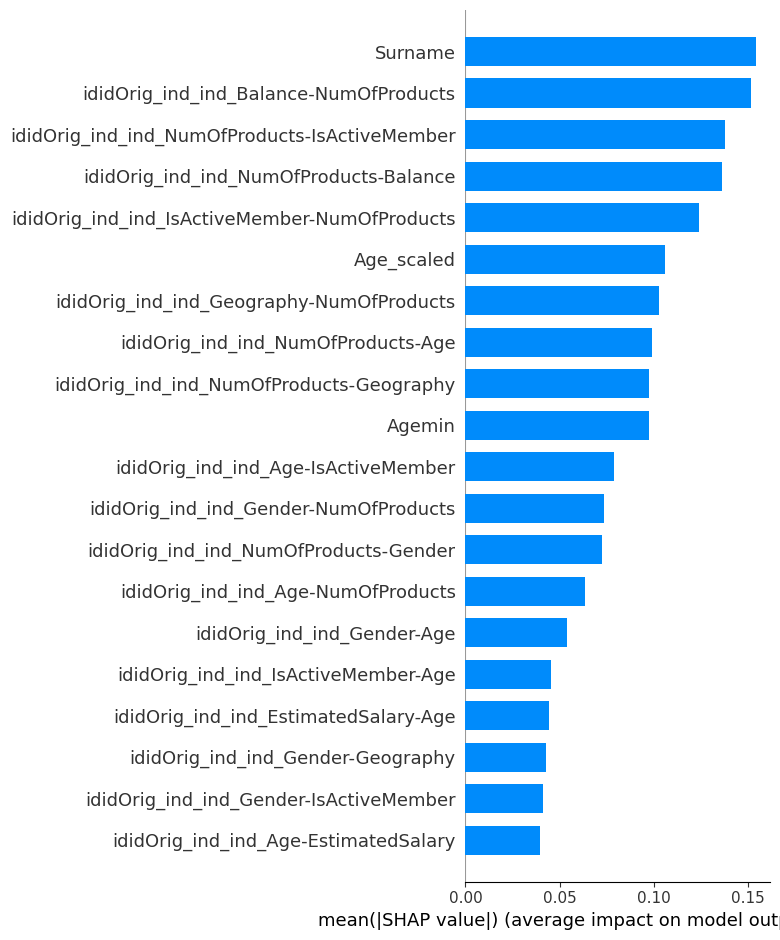

In [21]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(train_pool)
shap.summary_plot(shap_values, X_train, plot_type="bar")

## Prediction and Submission

In [22]:
join_cols=list(df_orig.columns.drop(['Exited']))
df_orig.rename(columns={'Exited':'Exited_Orig'},inplace=True)
df_orig['Exited_Orig']=df_orig['Exited_Orig'].map({0:1,1:0})
df_test_ov=df_test_ov.merge(df_orig,on=join_cols,how='left')[['id','Exited_Orig']].fillna(-1)
df_test_ov.head()

,id,Exited_Orig
0,165034,-1.0
1,165035,-1.0
2,165036,-1.0
3,165037,-1.0
4,165038,-1.0


In [23]:
y_pred = test_preds.mean(axis=0)
df_sub = df_test_ov[['id','Exited_Orig']]
df_sub['Exited'] = np.where(df_sub.Exited_Orig==-1,y_pred,df_sub.Exited_Orig)
df_sub.drop('Exited_Orig',axis=1,inplace=True)
df_sub.head()

,id,Exited
0,165034,0.014194
1,165035,0.871893
2,165036,0.011646
3,165037,0.176502
4,165038,0.409719


In [24]:
df_sub.to_csv("submission.csv",index=False)

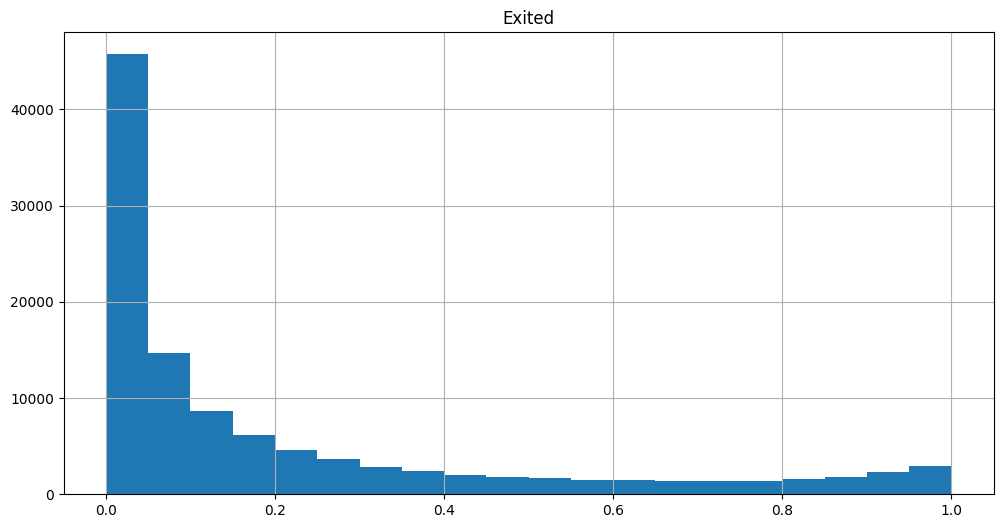

In [25]:
df_sub.hist(column='Exited', bins=20, range=[0,1],figsize=(12,6))
plt.show()